# Plots of the Time Series of Temperature and Load for the GODEEEP Deep Dive One Webinar


In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
load_data_input_dir =  '/Users/burl878/Documents/GODEEEP/Data/Merged_BA_Loads/'
weather_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/wrf_to_tell_data/rcp85hotter_ssp5/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/load_analysis/figures/'


## Set the BA and Year to Plot


In [3]:
ba_to_plot = 'LDWP'
year_to_plot = 2050


## Read in the Load and Weather Data and Merge it Together


In [4]:
# Read in the weather file for the BA and year to plot and convert the temperature from Kelvin to Fahrenheit:
weather_df = pd.read_csv((os.path.join(weather_data_input_dir, (ba_to_plot + '_WRF_Hourly_Mean_Meteorology_' + str(year_to_plot) + '.csv'))))
weather_df['T2'] = (1.8 * (weather_df['T2'] - 273)) + 32

# Read in the load file for the BAU case, subset to just the BA to plot, rename the load variable, and subset to just the variables we need:
bau_df = pd.read_csv((os.path.join(load_data_input_dir, ('Total_Loads_BAU_Climate_' + str(year_to_plot) + '.csv'))))
bau_df = bau_df[bau_df['BA'] == ba_to_plot]
bau_df.rename(columns={'Total_Load_MWh': 'BAU_Load_MWh'}, inplace=True)
bau_df = bau_df[['Time_UTC', 'BAU_Load_MWh']].copy()

# Read in the load file for the NZ case, subset to just the BA to plot, rename the load variable, and subset to just the variables we need:
nz_df = pd.read_csv((os.path.join(load_data_input_dir, ('Total_Loads_NetZeroNoCCS_Climate_' + str(year_to_plot) + '.csv'))))
nz_df = nz_df[nz_df['BA'] == ba_to_plot]
nz_df.rename(columns={'Total_Load_MWh': 'NZ_Load_MWh'}, inplace=True)
nz_df = nz_df[['Time_UTC', 'NZ_Load_MWh']].copy()

# Merge the three dataframes together based on common UTC times:
merged_df = weather_df.merge(bau_df, how ='left', on='Time_UTC').merge(nz_df,how ='left', on='Time_UTC')

# Convert the time to a datetime variable:
merged_df['Time_UTC'] = pd.to_datetime(merged_df['Time_UTC'], format='%Y-%m-%d %H:%M:%S')

# Normalize the loads to their peak value:
merged_df['BAU_Load_Normalized'] = (merged_df['BAU_Load_MWh'] / merged_df['BAU_Load_MWh'].max())
merged_df['NZ_Load_Normalized'] = (merged_df['NZ_Load_MWh'] / merged_df['NZ_Load_MWh'].max())

# Compute the date of the peak load set the bounds for the peak demand plots:
peak_day = merged_df['Time_UTC'].loc[merged_df['NZ_Load_MWh'].idxmax()] 
peak_min_date = pd.to_datetime(peak_day) - timedelta(days=1.5)
peak_max_date = pd.to_datetime(peak_day) + timedelta(days=1.5)


## Make the Time Series Plot


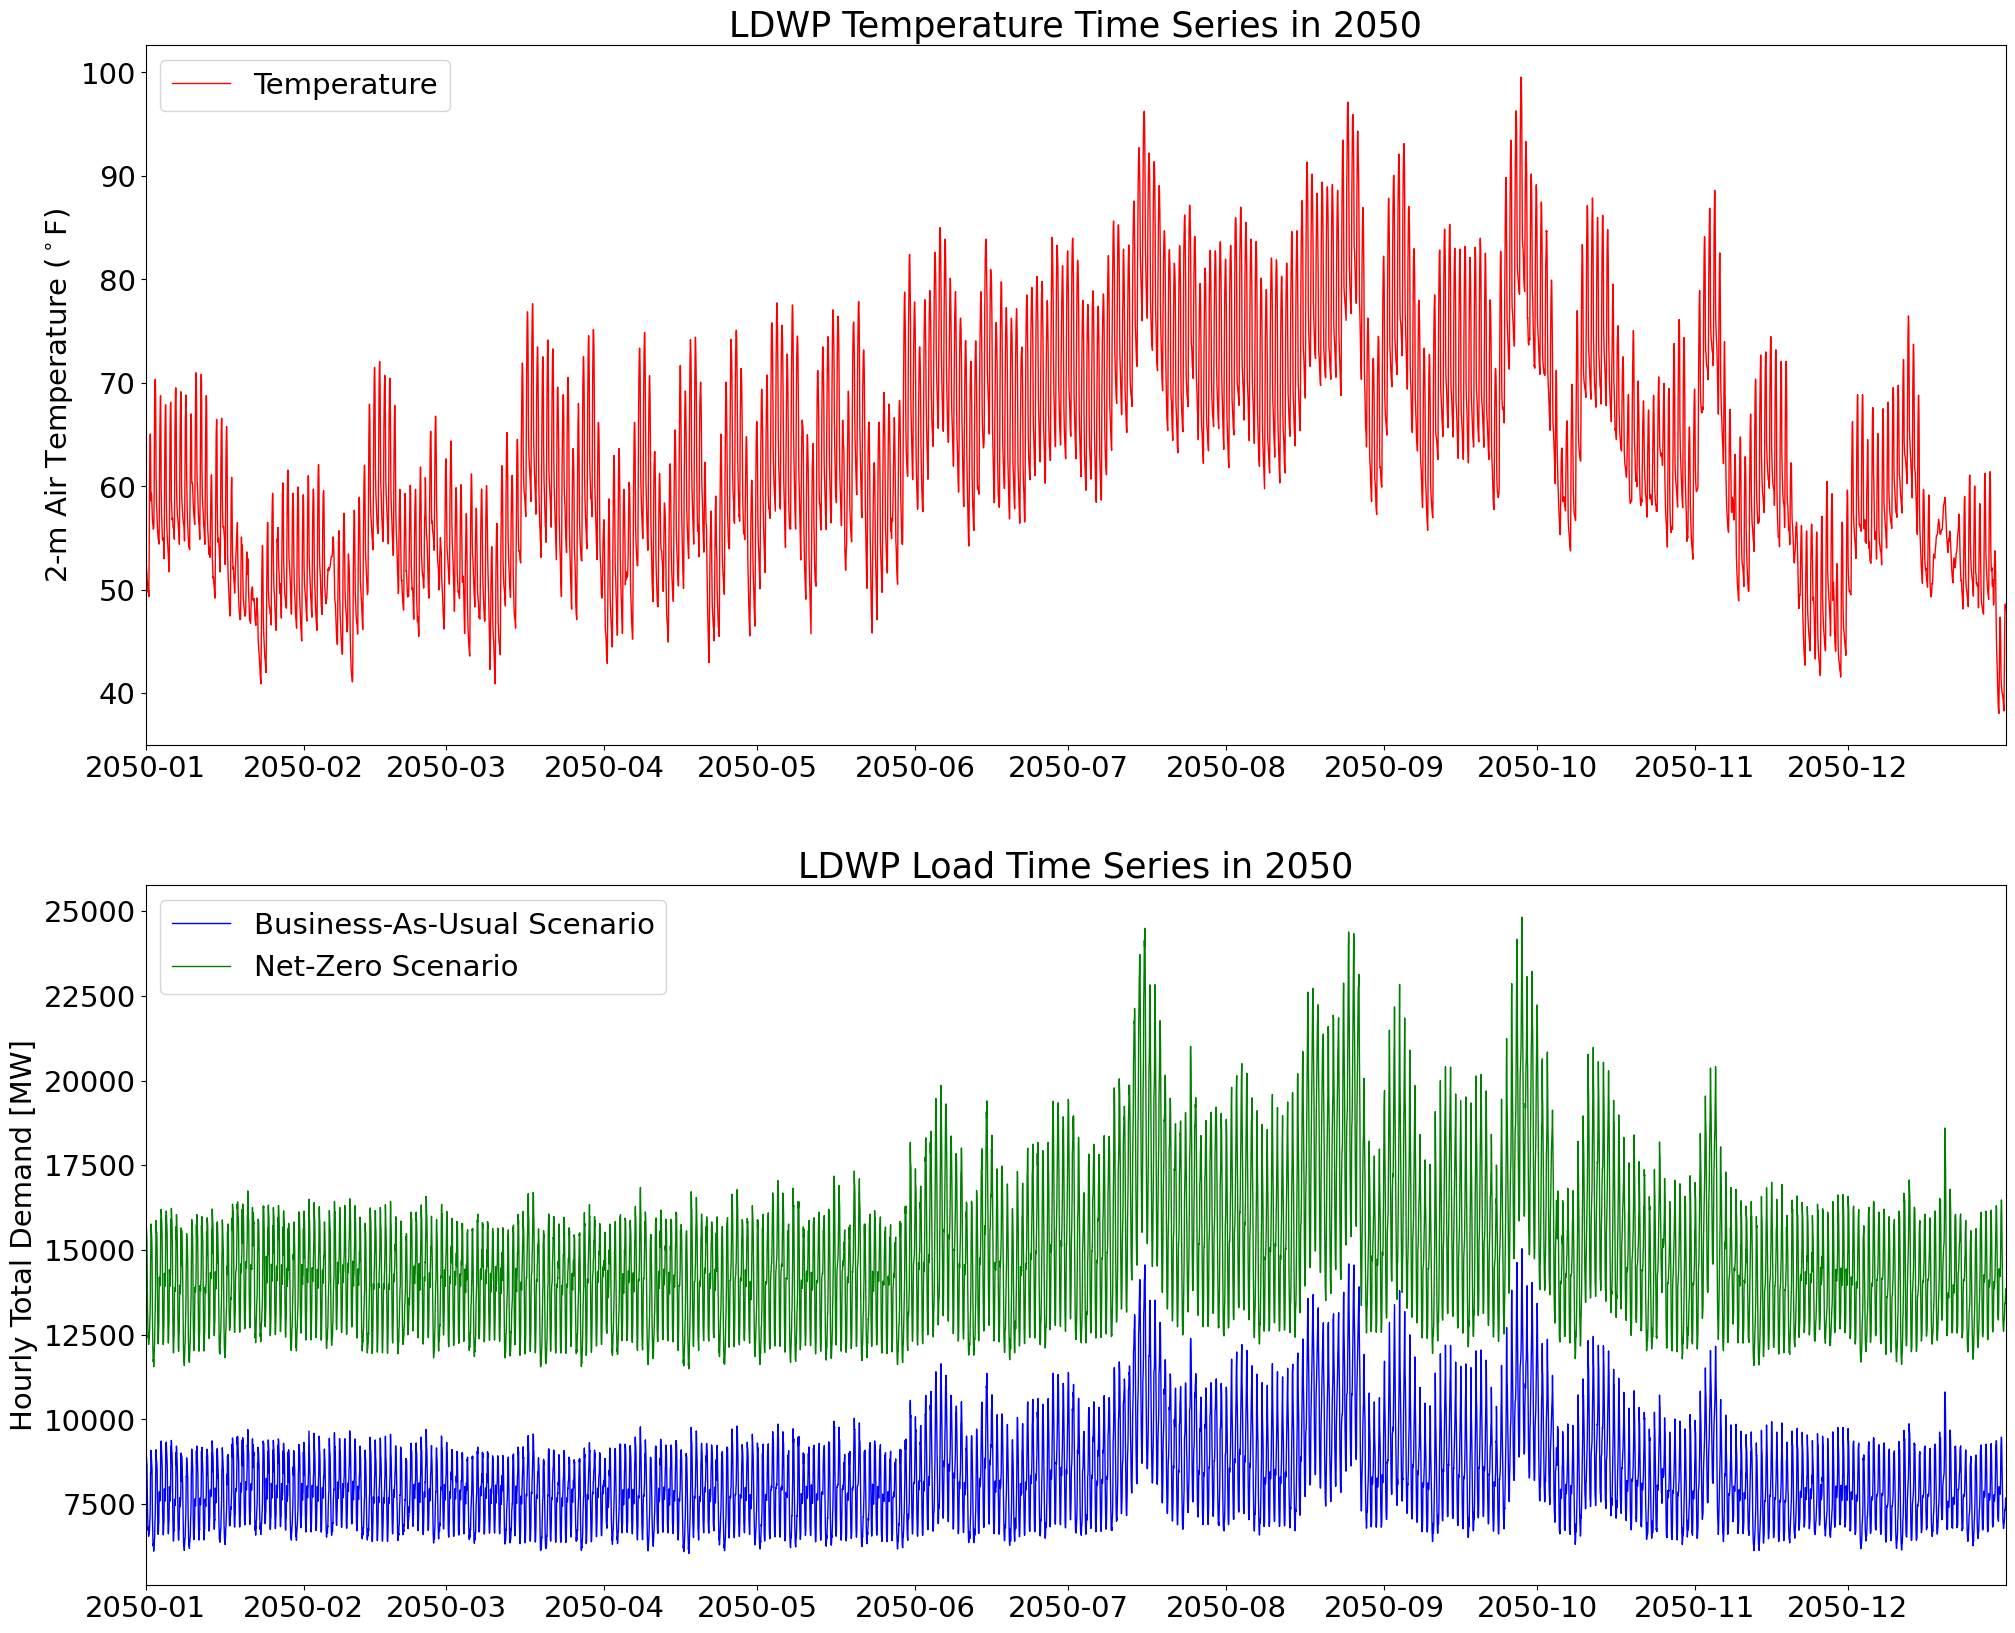

In [5]:
# Make the plot:
plt.figure(figsize=(24, 20))
plt.rcParams['font.size'] = 21
    
plt.subplot(211)
plt.plot(merged_df['Time_UTC'], merged_df['T2'], color='r', linestyle='-', label='Temperature', linewidth=1)
plt.legend(loc='upper left', prop={'size': 21})
plt.xlim([merged_df['Time_UTC'].min(), merged_df['Time_UTC'].max()])
plt.ylabel('2-m Air Temperature ($^\circ$F)')
plt.title((ba_to_plot + ' Temperature Time Series in ' + str(year_to_plot)))

plt.subplot(212)
plt.plot(merged_df['Time_UTC'], merged_df['BAU_Load_MWh'], color='b', linestyle='-', label='Business-As-Usual Scenario', linewidth=1)
plt.plot(merged_df['Time_UTC'], merged_df['NZ_Load_MWh'], color='g', linestyle='-', label='Net-Zero Scenario', linewidth=1)
plt.legend(loc='upper left', prop={'size': 21})
plt.xlim([merged_df['Time_UTC'].min(), merged_df['Time_UTC'].max()])
plt.ylabel('Hourly Total Demand [MW]')
plt.title((ba_to_plot + ' Load Time Series in ' + str(year_to_plot)))

plt.savefig(os.path.join(image_output_dir, (ba_to_plot + '_Load_Time_Series_' + str(year_to_plot) + '.png')), dpi=300, bbox_inches='tight', facecolor='white')


## Make the Peak Week Plot:


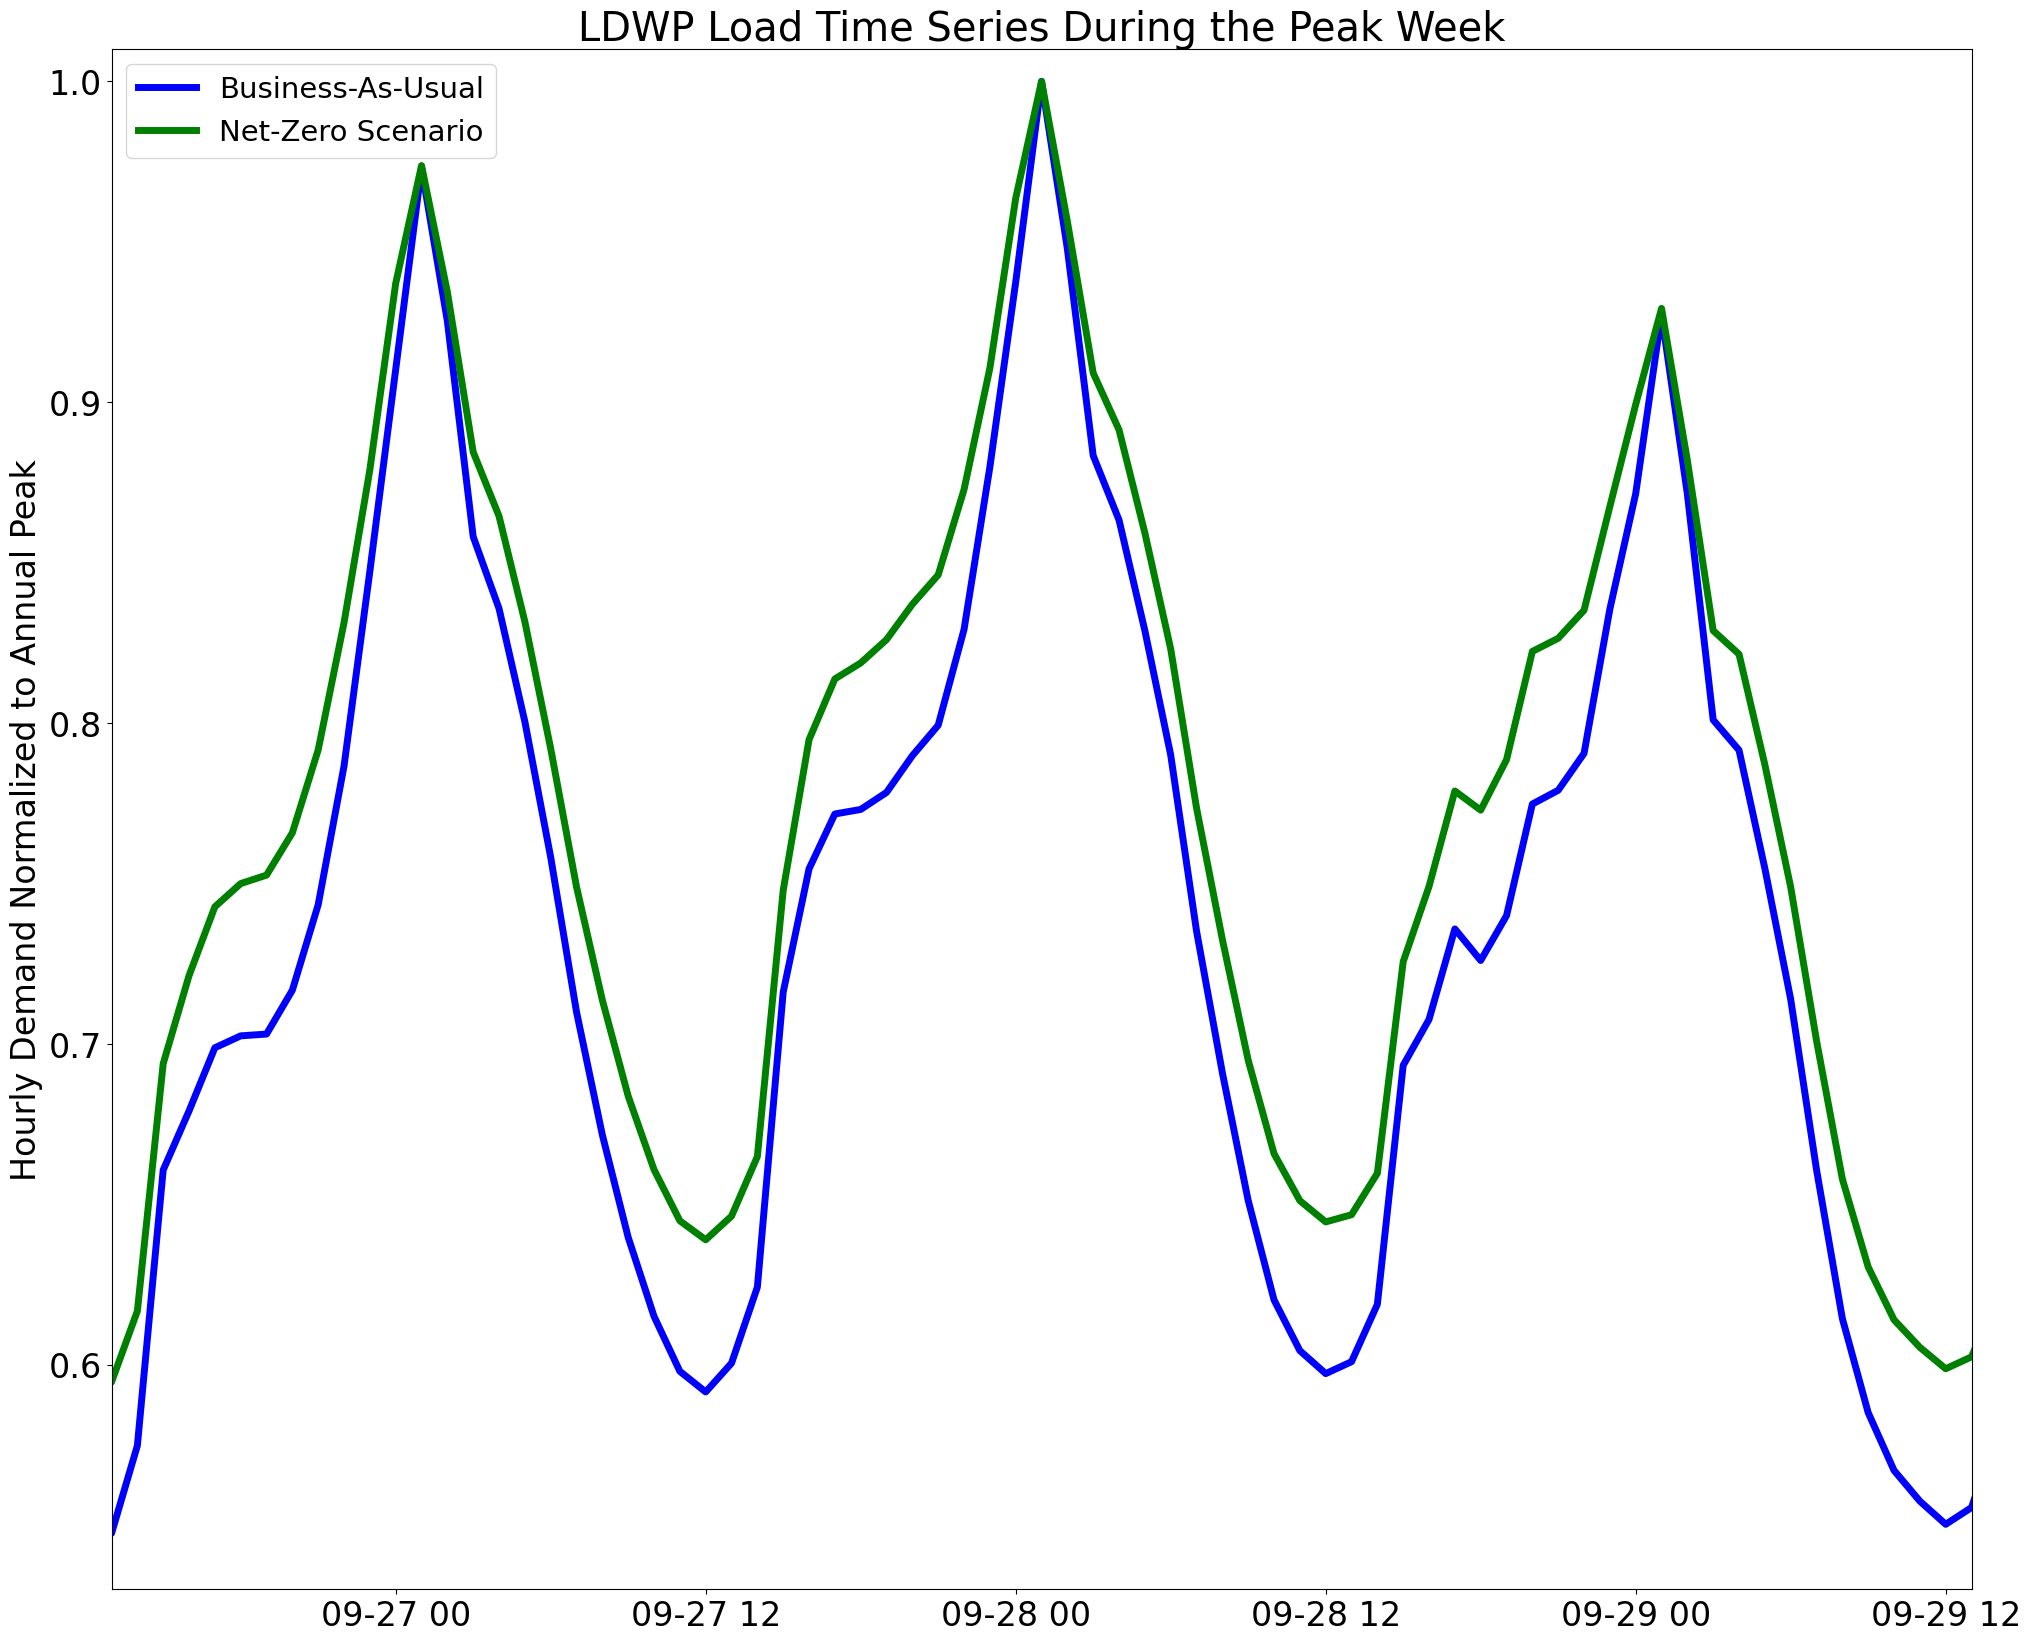

In [9]:
# Make the plot:
plt.figure(figsize=(24, 20))
plt.rcParams['font.size'] = 24
    
plt.plot(merged_df['Time_UTC'], merged_df['BAU_Load_Normalized'], color='b', linestyle='-', label='Business-As-Usual', linewidth=5)
plt.plot(merged_df['Time_UTC'], merged_df['NZ_Load_Normalized'], color='g', linestyle='-', label='Net-Zero Scenario', linewidth=5)
plt.legend(loc='upper left', prop={'size': 21})
plt.xlim([peak_min_date, peak_max_date])
plt.ylim([0.53, 1.01])
plt.ylabel('Hourly Demand Normalized to Annual Peak')
plt.title((ba_to_plot + ' Load Time Series During the Peak Week'))

plt.savefig(os.path.join(image_output_dir, (ba_to_plot + '_Peak_Week_Time_Series_' + str(year_to_plot) + '.png')), dpi=300, bbox_inches='tight', facecolor='white')
